# Covid 19 data plotter

With the following cell, the data is updated. Running it the first time downloads ~360 MB of data. 

(File size might be higher, depending on the number of days without lockdown since the creation of this file)

In [1]:
!git submodule update --init

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pandas as pd
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
def load_hopkis_data(sdate, edate, nbDaysbtw2dates=1, path="COVID-19"):
    """ Reads and returns the John Hoppkins university COVID 19 dataset """

    #sdate = date(2020,1,22)   # start date
    #edate = date(2021,3,13)   # end date
    date_modified=sdate
    dates=[sdate]

    while date_modified<edate:
        date_modified+=timedelta(days=nbDaysbtw2dates) 
        dates.append(date_modified)
    #print(dates) 

    basepath = "csse_covid_19_data/csse_covid_19_daily_reports"

    alldata = None
    for date in dates:
        filename = f"{date.month:02d}-{date.day:02d}-{date.year}.csv"
        fullpath = os.path.join(path, basepath, filename)

        with open(fullpath, "r") as file:
            header = file.readline()

        headerlist = header.split(",")
        country_index = None
        confirmed_index = None
        deaths_index = None
        recovered_index = None
        for i in range(len(headerlist)):
            if headerlist[i].replace("\n", "") in ["Country_Region", "Country/Region"]:
                country_index = i
            if headerlist[i].replace("\n", "") in ["Confirmed"]:
                confirmed_index = i
            if headerlist[i].replace("\n", "") in ["Deaths"]:
                deaths_index = i
            if headerlist[i].replace("\n", "") in ["Recovered"]:
                recovered_index = i
        #print(country_index, confirmed_index, deaths_index, recovered_index)

        #data = np.genfromtxt(fullpath, skip_header=1, delimiter=",", usecols=(country_index, confirmed_index, deaths_index, recovered_index))
        df = pd.read_csv(fullpath, sep=",", usecols=(country_index, confirmed_index, deaths_index, recovered_index), header=0,names=["country", "confirmed", "deaths", "recovered"])
        df = df.fillna(0)

        df = df.groupby("country").sum()
        df.index.name = "country"
        df.reset_index(inplace=True)

        #print(df)
        df["date"] = date
        if alldata is None:
            alldata = df
        else:
            alldata = pd.concat([alldata, df])
        #print(df)
        
    #print(alldata)
    return alldata

In [4]:
# load data
df = load_hopkis_data(date(2020,1,22),date(2021,3,13))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71067 entries, 0 to 191
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    71067 non-null  object 
 1   confirmed  71067 non-null  float64
 2   deaths     71067 non-null  float64
 3   recovered  71067 non-null  float64
 4   date       71067 non-null  object 
dtypes: float64(3), object(2)
memory usage: 3.3+ MB


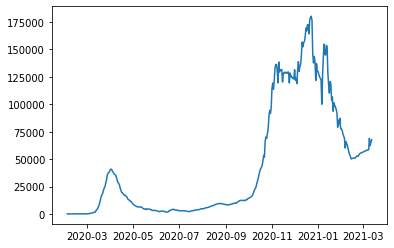

In [5]:
# make an example plot
selection = df[df["country"] == "Germany"]
#print(selection["date"].to_numpy())
x = selection["date"].to_numpy()[1:]
y = selection["confirmed"].to_numpy()[1:]-selection["confirmed"].to_numpy()[:-1]
x_avg = x[6:]
y_avg = np.convolve(y, np.ones(7), 'valid')
plt.plot(x_avg, y_avg)
plt.show()

In [6]:
# make an interactive plot
def f(country="Germany", data="confirmed", days2average=7, cumulative=False):
    # make an example plot
    selection = df[df["country"] == country]
    try:
        # select data
        x = selection["date"].to_numpy()[1:]
        y = selection[data].to_numpy()[1:]
        if not cumulative:
            y = y - selection[data].to_numpy()[:-1]
        
        # take a rolling average
        x_avg = x[days2average-1:]
        y_avg = np.convolve(y, np.ones(days2average), 'valid')/days2average

        #plot
        plt.plot(x_avg, y_avg)
        plt.xlabel("date")
        plt.ylabel("cumulative "*cumulative+"daily "*(not cumulative)+f"{data}".replace("confirmed", "cases"))
    except:
        print(f"Data for {country} cannot be processed!")
    #plt.show()
interact(f, country=np.sort(df["country"].unique()), data=["confirmed", "deaths", "recovered"], days2average=(1, 35, 1), cumulative=False)

interactive(children=(Dropdown(description='country', index=79, options=(' Azerbaijan', 'Afghanistan', 'Albani…

<function __main__.f(country='Germany', data='confirmed', days2average=7, cumulative=False)>